# Network Intrusion System
네트워크 탐지 시스템을 구현하기 위한 아키텍쳐는 다음과 같다.
<p align="center"><img src=image\flowchart.png width="600" height="200"/>

### Data Set
데이터 셋은 NSL-KDD를 사용한다. NSL- KDD는 다음과 같은 4가지의 공격 종류를 가진다.
<p align="center"><img src=image/AttackType.png width="400" height="200"/>

위의 데이터 셋에는 단순한 침입 탐지 네트워크에서 볼 수 있는 인터넷 트래픽의 기록이 포함되어 있으며, 실제 IDS에서 마주치는 트래픽의 유형이며 존재의 흔적만이 남아있다. 

데이터 셋에는 기록 당 43가지의 특징을 가지고 있으며, 이 중 41개의 특징은 트래픽 입력 자체를 참조하여 마지막 2개는 레이블(노말 또는 공격)과 점수(트래픽 입력 자체의 심각도)이다.

진행되는 단계는 다음과 같다.

1. 데이터 마이닝
2. 군집화
3. 인공신경망


## Data Processing


In [2]:
#module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random 

#model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#### data extracion
공격자에 대한 특징을 추출하기 위해 nsl-kdd 데이터를 살펴본다.

In [3]:
# fetch the training file
file_path_20_percent = './nsl-kdd/KDDTrain+_20Percent.txt'
file_path_full_training_set = './nsl-kdd/KDDTrain+.txt'
file_path_test = './nsl-kdd/KDDTest+.txt' 

#df = pd.read_csv(file_path_20_percent)
df = pd.read_csv(file_path_full_training_set)
test_df = pd.read_csv(file_path_test)

데이터에는 열에 대한 정보가 없기 때문에, 이것을 정의하여 데이터를 잘 정리할 수 있도록 한다. 

In [4]:
#add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

df.columns = columns
test_df.columns = columns

# sanity check
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


데이터를 분류할 때 normal & Attack 로 이진 분류를 하는 것과 Iris 데이터 셋과 같은 결과가 여러가지인 다중 분류가 있다. 

따라서 처음에는 normal & Attack 결과로 나오는 이진 분류로 도출하고 이후에는  DOS,Probe,U2R,R2L 결과를 도출해내는 다중 분류를 도출한다.

## 이중 분류

In [5]:
# all attack to 1, else normal to 0
is_attack = df.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_df.attack.map(lambda a: 0 if a == 'normal' else 1)

#data_with_attack = df.join(is_attack, rsuffix='_flag')
df['attack_flag'] = is_attack
test_df['attack_flag'] = test_attack

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag
0,0,udp,other,SF,146,0,0,0,0,0,...,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1


공격의 종류를 살펴보면 다음과 같다. 
### Denial of Service attacks:
    apache2
    back
    land
    neptune
    mailbomb
    pod
    processtable
    smurf
    teardrop
    udpstorm
    worm
### Probe attacks:
    ipsweep
    mscan
    nmap
    portsweep
    saint
    satan
    Privilege escalation attacks
    buffer_overflow
    loadmdoule
    perl
    ps
    rootkit
    sqlattack
    xterm
### Remote access attacks
    ftp_write
    guess_passwd
    http_tunnel
    imap
    multihop
    named
    phf
    sendmail
    snmpgetattack
    snmpguess
    spy
    warezclient
    warezmaster
    xclock
    xsnoop

## 다중 분류

In [7]:
# lists to hold our attack classifications
dos_attacks = ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm']
probe_attacks = ['ipsweep','mscan','nmap','portsweep','saint','satan']
privilege_attacks = ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm']
access_attacks = ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop']

# we will use these for plotting below
attack_labels = ['Normal','DoS','Probe','Privilege','Access']

# helper function to pass to data frame mapping
def map_attack(attack):
    if attack in dos_attacks:
        # dos_attacks map to 1
        attack_type = 1
    elif attack in probe_attacks:
        # probe_attacks mapt to 2
        attack_type = 2
    elif attack in privilege_attacks:
        # privilege escalation attacks map to 3
        attack_type = 3
    elif attack in access_attacks:
        # remote access attacks map to 4
        attack_type = 4
    else:
        # normal maps to 0
        attack_type = 0
        
    return attack_type

# map the data and join to the data set
attack_map = df.attack.apply(map_attack)
df['attack_map'] = attack_map

test_attack_map = test_df.attack.apply(map_attack)
test_df['attack_map'] = test_attack_map

# view the result
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_flag,attack_map
0,0,udp,other,SF,146,0,0,0,0,0,...,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,0,0
1,0,tcp,private,S0,0,0,0,0,0,0,...,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,1,1
2,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,0,0
3,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,0.0,0.00,normal,21,0,0
4,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21,1,1


In [8]:
# use a crosstab to get attack vs protocol
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
back,0,956,0
buffer_overflow,0,30,0
ftp_write,0,8,0
guess_passwd,0,53,0
imap,0,11,0
ipsweep,3117,482,0
land,0,18,0
loadmodule,0,9,0
multihop,0,7,0


대부분의 공격이 특정 프로토콜을 대상으로 한다는 것을 알 수 잇다. 교차 프로토콜 공격인 satan,nmap,ipsweep가 있다. 
정산 트래픽에서 icmp 데이터가 발견되는 빈도 또한 낮다.

In [10]:
# helper function for drawing mulitple charts.
def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        
    return axs   

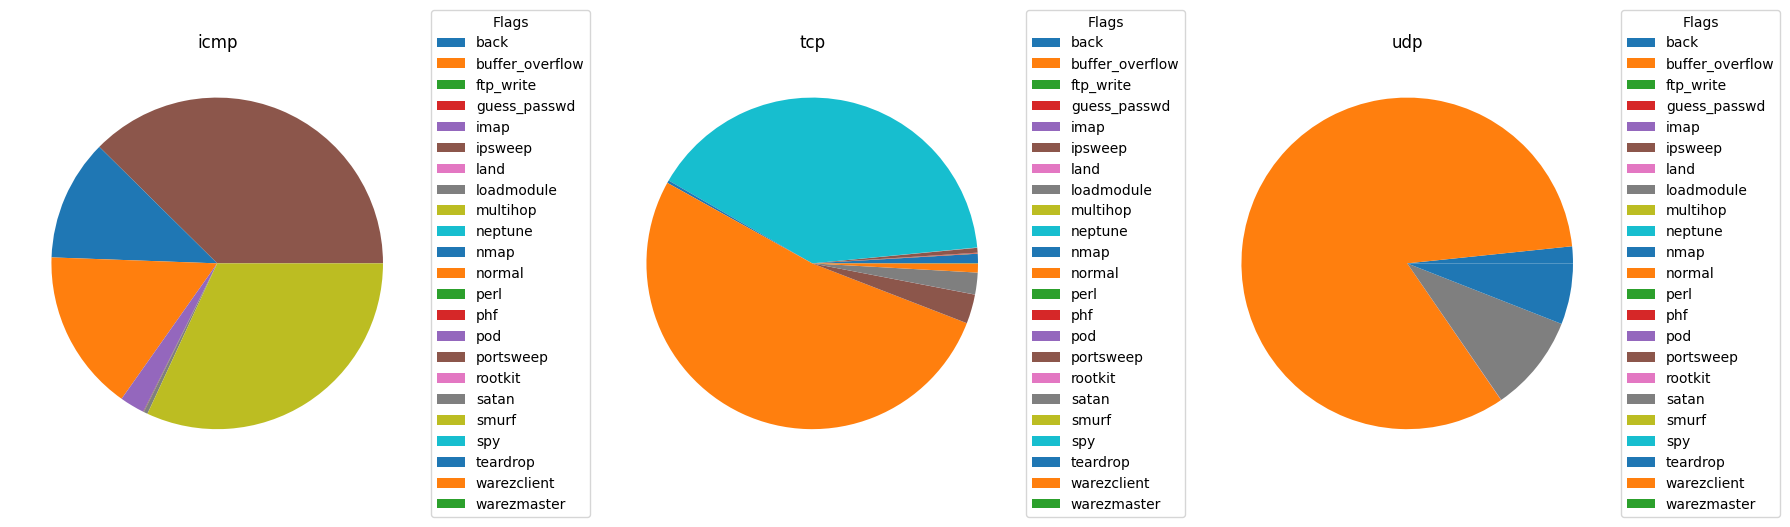

In [11]:
# get the series for each protocol
icmp_attacks = attack_vs_protocol.icmp
tcp_attacks = attack_vs_protocol.tcp
udp_attacks = attack_vs_protocol.udp

# create the charts
bake_pies([icmp_attacks, tcp_attacks, udp_attacks],['icmp','tcp','udp'])
plt.show()

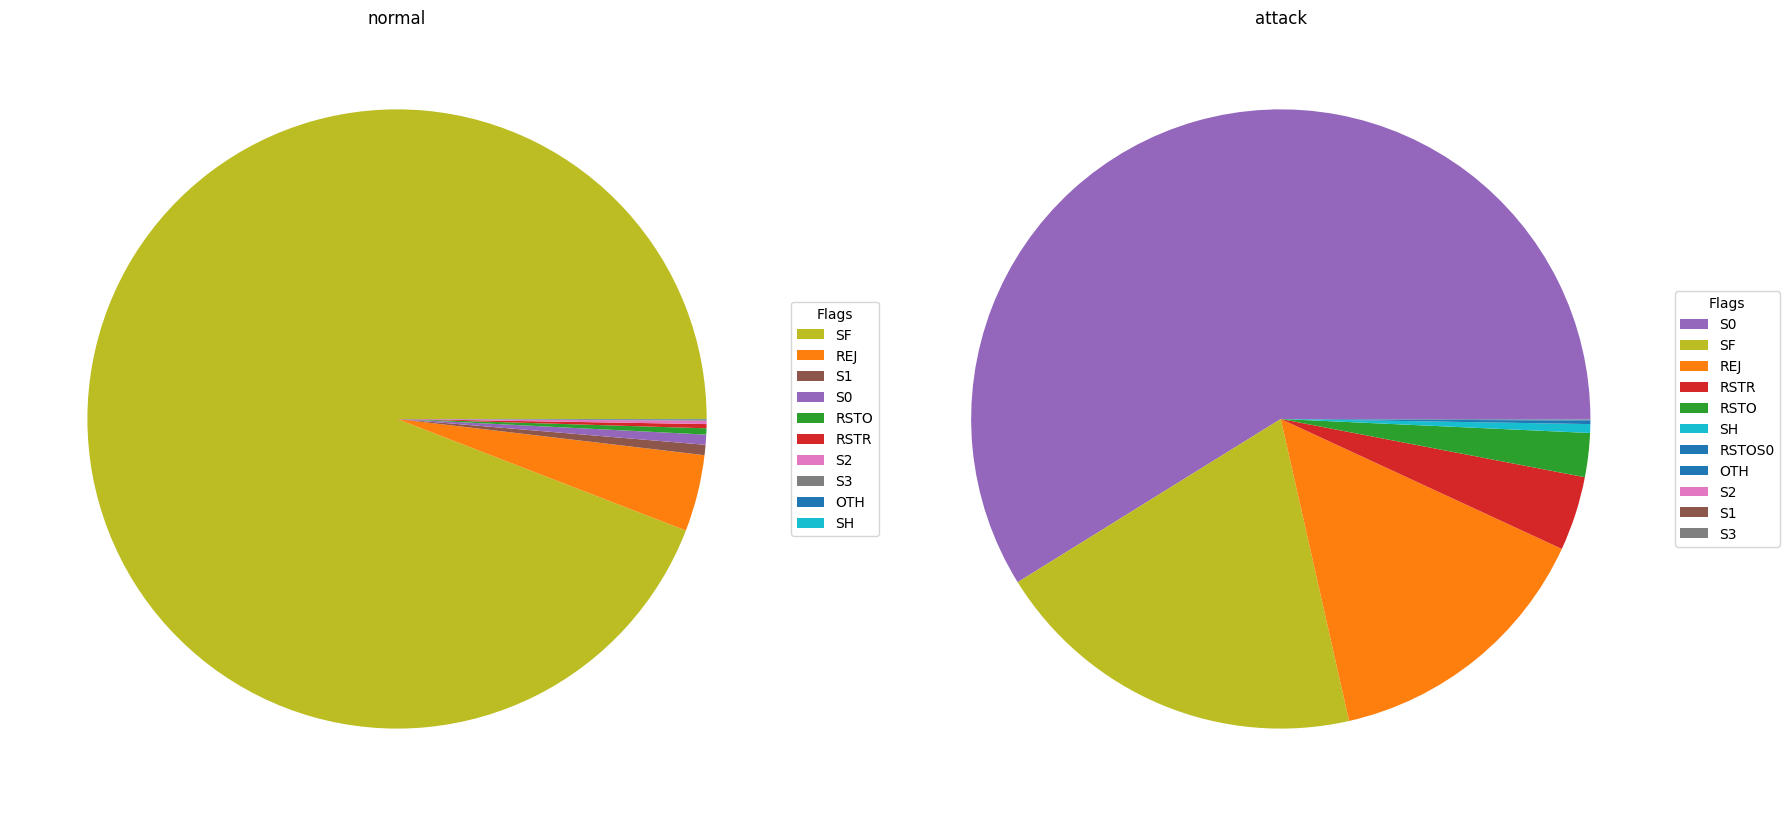

In [12]:
# get a series with the count of each flag for attack and normal traffic
normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

# create the charts
flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'])        
plt.show()

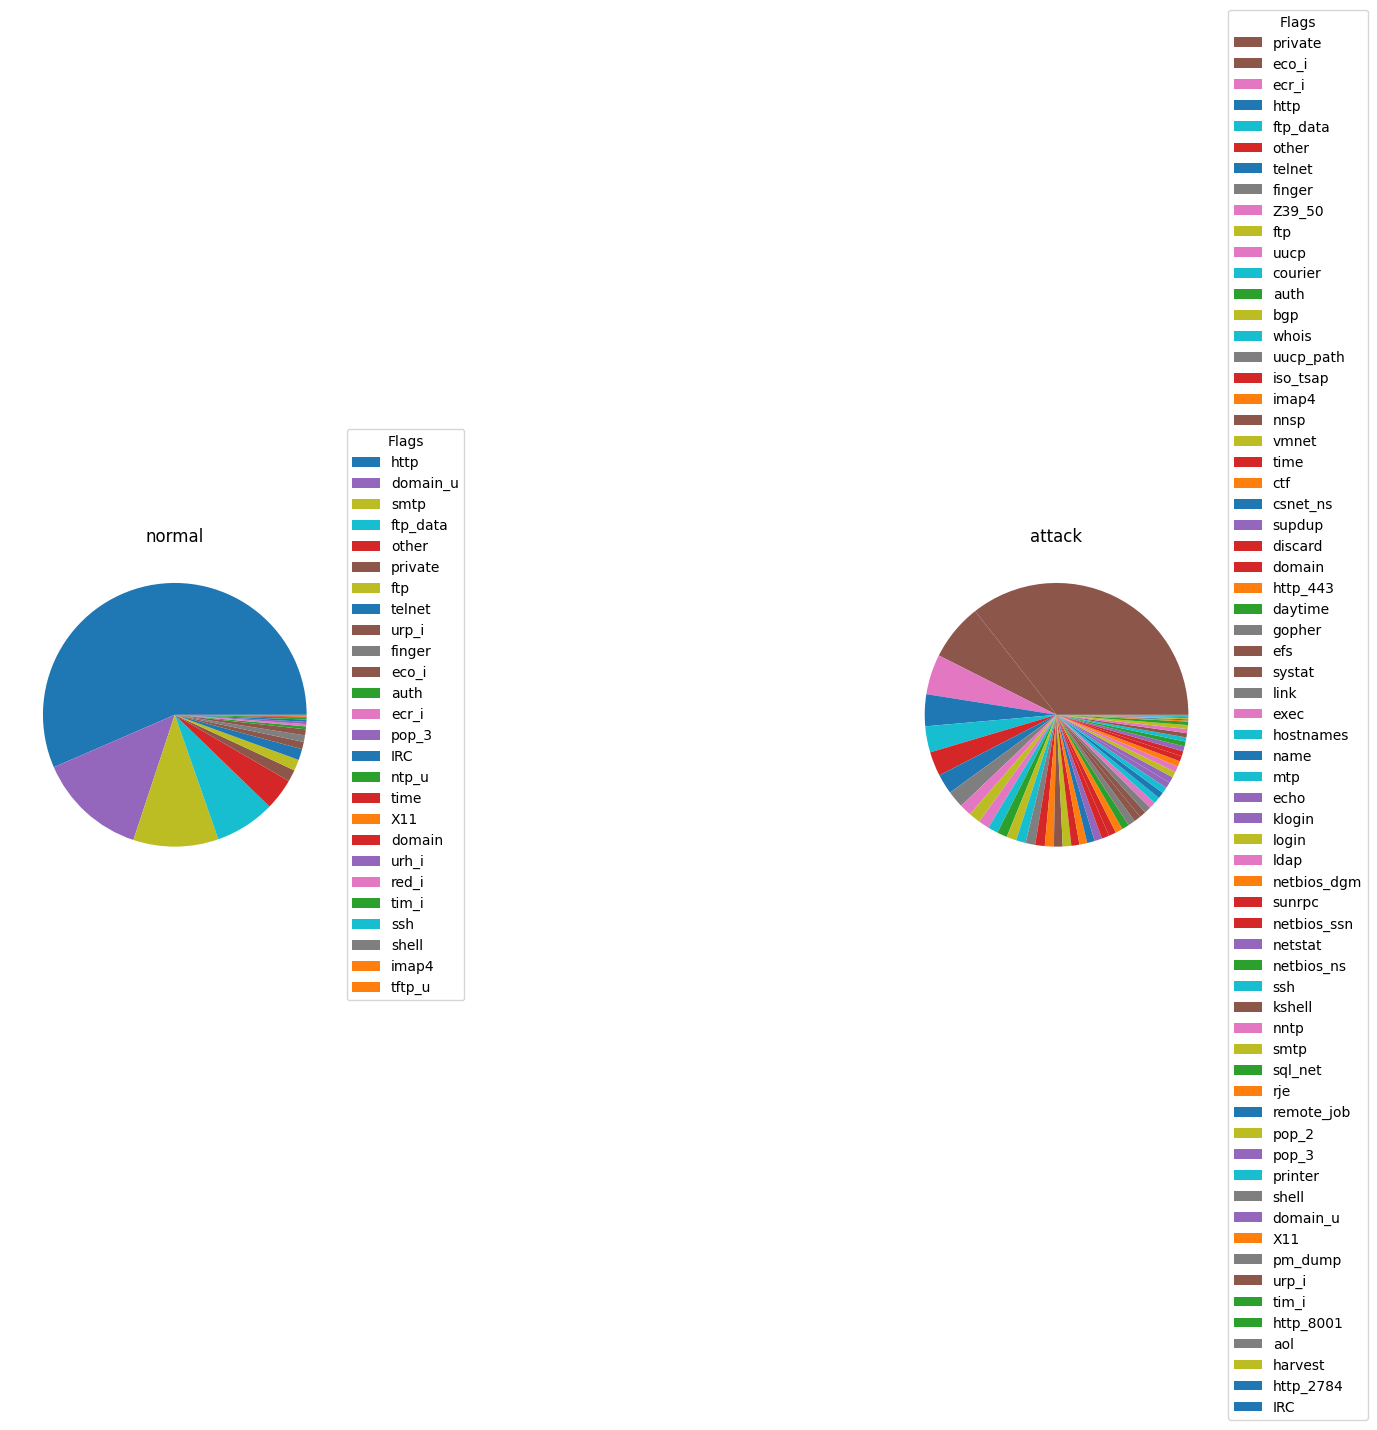

In [13]:
# get a series with the count of each service for attack and normal traffic
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

# create the charts
service_axs = bake_pies([normal_services, attack_services], ['normal','attack'])        
plt.show()

일반 트래픽의 상당량이 http인 반면에 우리의 공격 트래픽은 곳곳에 퍼져있다. 이는 공격이 시스템에 대한 다양한 경로를 검색하고 있다는 것을 의미한다. 잘 이동한 경로도 있지만 그렇지 못한 경로도 있다.

## Feature Engineering
특징 구축을 시작할 것 이다.. protocol_type, service 그리고 flag를 사용하는 것이 좋을 것같다. 이유는 충분한 차이가 있기 떄문에 기본적인 수준의 식별을 얻을 수 있다. 또한 기본적인 숫자 데이터, duration, src_bytes,dst_bytes도 입력한다. 이 모든 것들은 패킷 캡처를 통해 쉽게 구해낼 수 있다. 

In [14]:
# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'service', 'flag']
encoded = pd.get_dummies(df[features_to_encode])
test_encoded_base = pd.get_dummies(test_df[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_df.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

# we'll also need to reorder the columns to match, so let's get those
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order].fillna(0)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = encoded.join(df[numeric_features])
test_set = test_final.join(test_df[numeric_features])

In [15]:
# create our target classifications
binary_y = df['attack_flag']
multi_y = df['attack_map']

test_binary_y = test_df['attack_flag']
test_multi_y = test_df['attack_map']

# build the training sets
binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(to_fit, binary_y, test_size=0.6)
multi_train_X, multi_val_X, multi_train_y, multi_val_y = train_test_split(to_fit, multi_y, test_size = 0.6)

In [16]:
#Model fitting
# model for the binary classification
binary_model = RandomForestClassifier()
binary_model.fit(binary_train_X, binary_train_y)
binary_predictions = binary_model.predict(binary_val_X)

# calculate and display our base accuracty
base_rf_score = accuracy_score(binary_predictions,binary_val_y)
base_rf_score


0.9931863886536834

In [18]:
# define the list of models that we want to test
models = [
    RandomForestClassifier(),
    LogisticRegression(max_iter=250),
    KNeighborsClassifier(),
]

# an empty list to capture the performance of each model
model_comps = []

# walk through the models and populate our list
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, binary_train_X, binary_train_y, scoring='accuracy')
    for count, accuracy in enumerate(accuracies):
        model_comps.append((model_name, count, accuracy))

<Axes: >

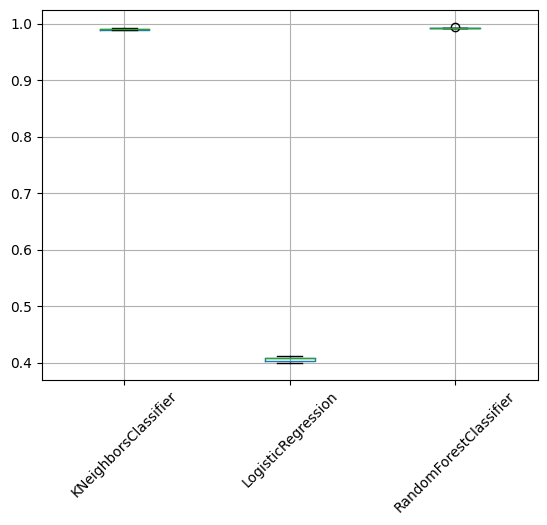

In [19]:
# a box plot will do well to show us overall performance and the variation in the models.
result_df = pd.DataFrame(model_comps, columns=['model_name', 'count', 'accuracy'])
result_df.pivot(index='count',columns='model_name',values='accuracy').boxplot(rot=45)

In [20]:
# a helper function for getting some analytical data about our predictions
def add_predictions(data_set,predictions,y):
    prediction_series = pd.Series(predictions, index=y.index)

    # we need to add the predicted and actual outcomes to the data
    predicted_vs_actual = data_set.assign(predicted=prediction_series)
    original_data = predicted_vs_actual.assign(actual=y).dropna()
    conf_matrix = confusion_matrix(original_data['actual'], 
                                   original_data['predicted'])
    
    # capture rows with failed predictions
    base_errors = original_data[original_data['actual'] != original_data['predicted']]
    
    # drop columns with no value
    non_zeros = base_errors.loc[:,(base_errors != 0).any(axis=0)]

    # idetify the type of error
    false_positives = non_zeros.loc[non_zeros.actual==0]
    false_negatives = non_zeros.loc[non_zeros.actual==1]

    # put everything into an object
    prediction_data = {'data': original_data,
                       'confusion_matrix': conf_matrix,
                       'errors': base_errors,
                       'non_zeros': non_zeros,
                       'false_positives': false_positives,
                       'false_negatives': false_negatives}
    
    return prediction_data

<Axes: >

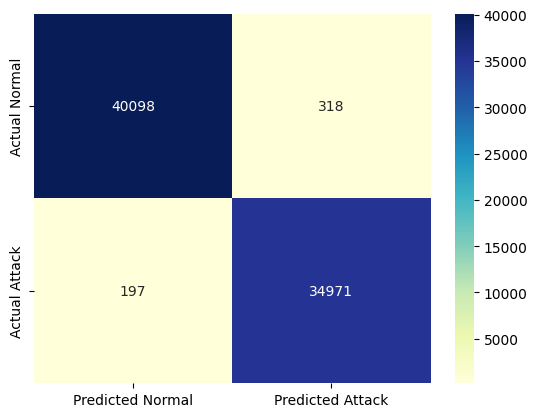

In [21]:
# capture our prediction data
binary_prediction_data = add_predictions(df,
                                         binary_predictions,
                                         binary_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=binary_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

In [22]:
# dataframe to store incorrect classification
binary_prediction_data['errors'].describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,attack_flag,attack_map,predicted,actual
count,515.000000,5.150000e+02,515.000000,515.000000,515.0,515.000000,515.000000,515.000000,515.000000,515.000000,...,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,69.996117,1.389700e+06,494.102913,0.007767,0.0,0.005825,0.106796,0.009709,0.081553,0.180583,...,0.058291,0.112019,0.029670,0.342757,0.375087,15.689320,0.382524,0.613592,0.617476,0.382524
std,825.309281,3.055965e+07,3453.334623,0.087873,0.0,0.098456,0.833545,0.181603,0.273949,2.082074,...,0.182076,0.255088,0.133819,0.458202,0.471203,5.165414,0.486476,0.988361,0.486476,0.486476
min,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.010000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020000,0.050000,0.010000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000
max,12743.000000,6.933756e+08,51633.000000,1.000000,0.0,2.000000,15.000000,4.000000,1.000000,38.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,1.000000,4.000000,1.000000,1.000000


In [23]:
# data minus the rows with no variance
binary_prediction_data['non_zeros'].describe()

,duration,src_bytes,dst_bytes,land,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,...,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level,attack_flag,attack_map,predicted,actual
count,515.000000,5.150000e+02,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,...,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000,515.000000
mean,69.996117,1.389700e+06,494.102913,0.007767,0.005825,0.106796,0.009709,0.081553,0.180583,0.013592,...,0.058291,0.112019,0.029670,0.342757,0.375087,15.689320,0.382524,0.613592,0.617476,0.382524
std,825.309281,3.055965e+07,3453.334623,0.087873,0.098456,0.833545,0.181603,0.273949,2.082074,0.115903,...,0.182076,0.255088,0.133819,0.458202,0.471203,5.165414,0.486476,0.988361,0.486476,0.486476
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.010000,0.010000,18.000000,0.000000,0.000000,1.000000,0.000000
75%,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.020000,0.050000,0.010000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000,1.000000
max,12743.000000,6.933756e+08,51633.000000,1.000000,2.000000,15.000000,4.000000,1.000000,38.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,1.000000,4.000000,1.000000,1.000000


In [24]:
# see the standard deviation of the false positives
binary_prediction_data['false_positives'].std()

C:\Users\qrkdb\AppData\Local\Temp\ipykernel_376\258231316.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  binary_prediction_data['false_positives'].std()


duration                            7.141238
src_bytes                      817829.273936
dst_bytes                         614.119472
land                                0.111622
urgent                              0.000000
hot                                 0.278683
num_failed_logins                   0.000000
logged_in                           0.166095
num_compromised                     0.056077
root_shell                          0.056077
num_root                            0.507625
num_file_creations                  0.000000
num_shells                          0.000000
num_access_files                    0.000000
is_guest_login                      0.000000
count                               1.834493
srv_count                           3.745341
serror_rate                         0.324587
srv_serror_rate                     0.316904
rerror_rate                         0.427179
srv_rerror_rate                     0.421643
same_srv_rate                       0.064254
diff_srv_r

In [25]:
# see the standard deviation of the false negatives
binary_prediction_data['false_negatives'].std()

C:\Users\qrkdb\AppData\Local\Temp\ipykernel_376\3677673454.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  binary_prediction_data['false_negatives'].std()


duration                       1.328863e+03
src_bytes                      4.939985e+07
dst_bytes                      5.467869e+03
land                           0.000000e+00
urgent                         1.589878e-01
hot                            1.293967e+00
num_failed_logins              2.934062e-01
logged_in                      3.743844e-01
num_compromised                3.351085e+00
root_shell                     1.722785e-01
num_root                       4.890032e+00
num_file_creations             1.391078e+00
num_shells                     2.342081e-01
num_access_files               1.589878e-01
is_guest_login                 1.413994e-01
count                          1.240522e+02
srv_count                      6.439826e+00
serror_rate                    1.343438e-01
srv_serror_rate                1.487738e-01
rerror_rate                    4.439811e-01
srv_rerror_rate                4.604670e-01
same_srv_rate                  4.326206e-01
diff_srv_rate                  2

<Axes: >

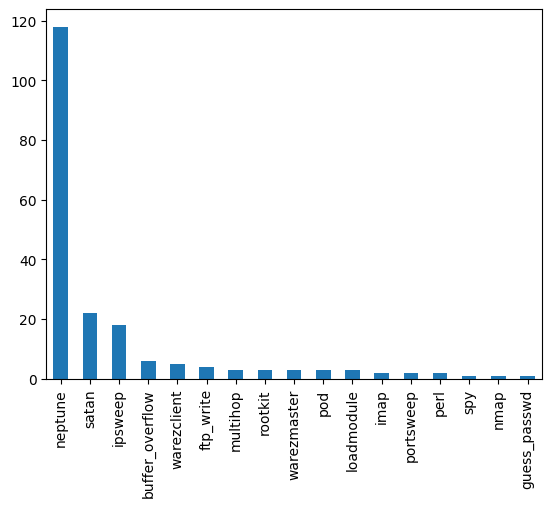

In [26]:
# distribution of false negatives--what attacks did we miss?
binary_prediction_data['false_negatives'].attack.value_counts().plot.bar()

In [27]:
# we'll need to pull these from the data set
outcomes = ['attack_flag','attack_map', 'actual']

# get the new features we're interested in and drop the outcomes
new_features = (binary_prediction_data['false_positives']==0).all(axis=0)
feature_cols = binary_prediction_data['false_positives'].loc[:,new_features]
feature_cols = feature_cols.drop(outcomes,axis=1)

# Let's get these in a list and take a look
new_feature_columns = list(feature_cols.columns)
new_feature_columns

['urgent',
 'num_failed_logins',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'is_guest_login']

In [28]:
# add the new freatures
to_fit_new_features = to_fit.join(df[new_feature_columns])

# build the training sets
new_feature_train_X, new_feature_val_X, new_feature_train_y, new_feature_val_y = train_test_split(to_fit_new_features, binary_y)

In [29]:
# model for the binary classification
new_feature_model = RandomForestClassifier()
new_feature_model.fit(new_feature_train_X, new_feature_train_y)
new_feature_predictions = new_feature_model.predict(new_feature_val_X)

# get the score for the model
new_feature_score = accuracy_score(new_feature_predictions,new_feature_val_y)

new_feature_score

0.9932048391706093

<Axes: >

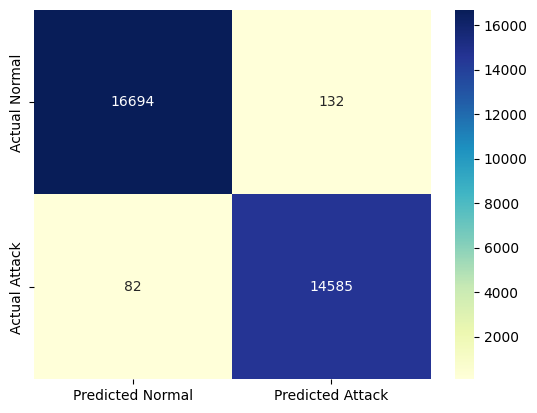

In [30]:
# capture the prediction data
new_prediction_data = add_predictions(df,
                                      new_feature_predictions,
                                      new_feature_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=new_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

<Axes: >

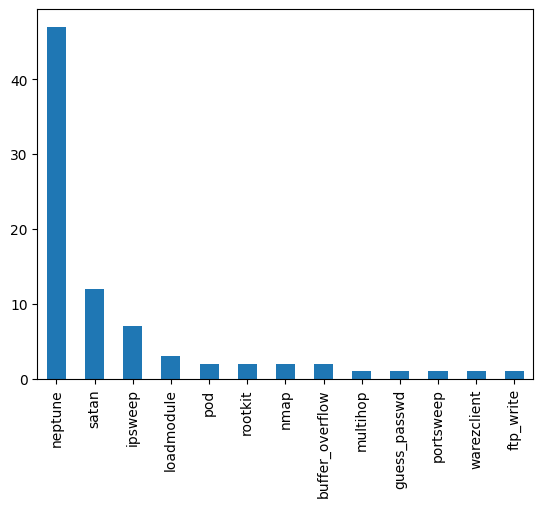

In [31]:
# distribuition of the false negatives--what attacks did we miss?
new_prediction_data['false_negatives'].attack.value_counts().plot.bar()

In [32]:
# model for the binary classification
full_model = RandomForestClassifier(random_state=1)
full_model.fit(to_fit, binary_y)
full_predictions = full_model.predict(test_set)

# get the score
full_score = accuracy_score(full_predictions,test_binary_y)
full_score

0.8035753892560884

<Axes: >

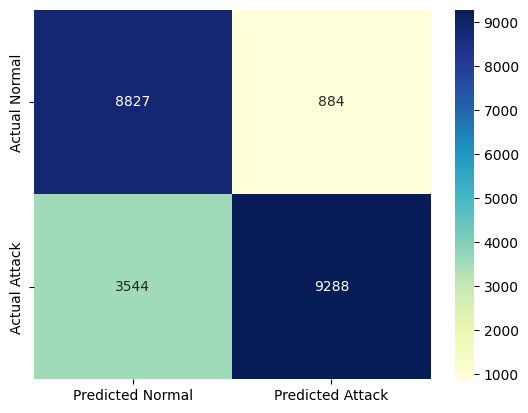

In [33]:
# capture the prediction data
full_prediction_data = add_predictions(test_df, full_predictions, test_binary_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=full_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted Normal','Predicted Attack'],
            yticklabels = ['Actual Normal','Actual Attack'],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

In [34]:
# create our label encoder
label_encoder = LabelEncoder()

# get the intial set of encoded features and encode them
features_to_encode = ['protocol_type', 'flag']
dummy_encoded = pd.get_dummies(df[features_to_encode])
test_dummy_encoded = pd.get_dummies(test_df[features_to_encode])

# now we'll label encode the service column
label_encoder.fit(df.service)
dummy_encoded['service'] = label_encoder.transform(df.service)
test_dummy_encoded['service'] = label_encoder.transform(test_df.service)

# get numeric features, we won't worry about encoding these at this point
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

# model to fit/test
to_fit = dummy_encoded.join(df[numeric_features])
test_set = test_dummy_encoded.join(test_df[numeric_features])

# make sure our columns match
print(to_fit.columns)
print(test_set.columns)

Index(['protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp',
       'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH',
       'service', 'duration', 'src_bytes', 'dst_bytes'],
      dtype='object')
Index(['protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp',
       'flag_OTH', 'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR',
       'flag_S0', 'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH',
       'service', 'duration', 'src_bytes', 'dst_bytes'],
      dtype='object')


In [35]:
# model for the binary classification
full_model = RandomForestClassifier(random_state=1)
full_model.fit(to_fit, binary_y)
full_predictions = full_model.predict(test_set)

# get the score
full_score = accuracy_score(full_predictions,test_binary_y)
full_score

0.7955462893137559

In [36]:
# add new features
to_fit_new_features = to_fit.join(df[new_feature_columns])
test_set_new_features = test_set.join(test_df[new_feature_columns])

In [37]:
# run the model
full_model.fit(to_fit_new_features,binary_y)
full_predictions = full_model.predict(test_set_new_features)

# get the score
full_score = accuracy_score(full_predictions,test_binary_y)
full_score

0.7964778423457393

In [38]:
# model for the mulit classification
multi_model = RandomForestClassifier()
multi_model.fit(multi_train_X, multi_train_y)
multi_predictions = multi_model.predict(multi_val_X)

# get the score
accuracy_score(multi_predictions,multi_val_y)

0.9766484970364098

In [39]:
# build the training sets
multi_feature_train_X, multi_feature_val_X, multi_feature_train_y, multi_feature_val_y = train_test_split(to_fit_new_features, multi_y)

In [40]:
# model for the mulit classification
multi_model = RandomForestClassifier()
multi_model.fit(multi_feature_train_X, multi_feature_train_y)
multi_predictions = multi_model.predict(multi_feature_val_X)

# get the score
accuracy_score(multi_predictions,multi_feature_val_y)

0.9775188137046328

<Axes: >

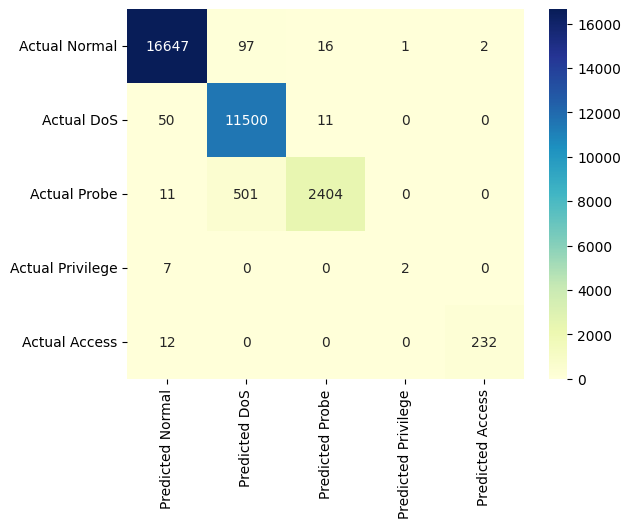

In [41]:
# capture the prediction data
multi_prediction_data = add_predictions(df, multi_predictions, multi_feature_val_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=multi_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted ' + x for x in attack_labels],
            yticklabels = ['Actual ' + x for x in attack_labels],
            cmap="YlGnBu",
            fmt='d',
            annot=True)

In [42]:
# fit on the full data set
multi_model.fit(to_fit_new_features, multi_y)
full_multi_predictions = multi_model.predict(test_set_new_features)

# get the score
accuracy_score(full_multi_predictions,test_multi_y)

0.7439116355409662

In [43]:
# run the model on the smaller column set
multi_model.fit(to_fit, multi_y)
full_multi_predictions = multi_model.predict(test_set)

# get the score
accuracy_score(full_multi_predictions,test_multi_y)

0.7682650933771016

<Axes: >

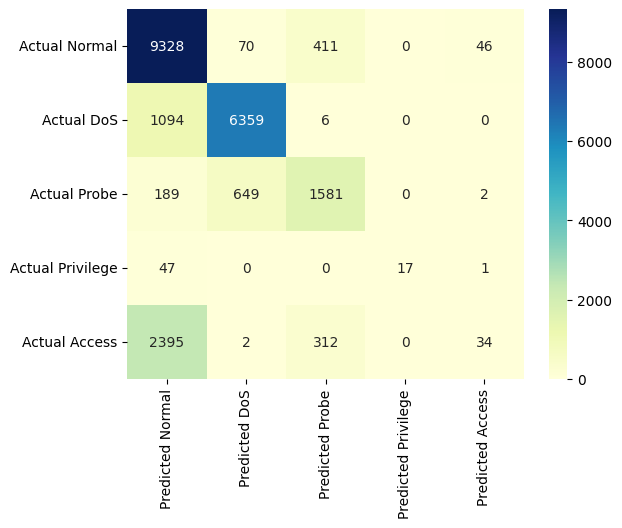

In [44]:
# build our prediction data
multi_prediction_data = add_predictions(df, full_multi_predictions, test_multi_y)

# create a heatmap of the confusion matrix
sns.heatmap(data=multi_prediction_data['confusion_matrix'],
            xticklabels = ['Predicted ' + x for x in attack_labels],
            yticklabels = ['Actual ' + x for x in attack_labels],
            cmap="YlGnBu",
            fmt='d',
            annot=True)